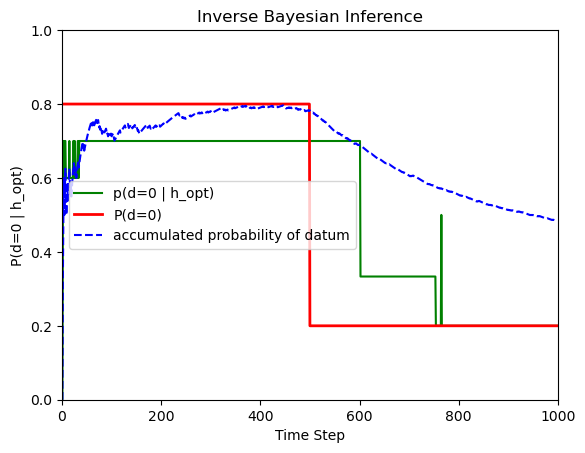

In [2]:
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt
import random
from collections import Counter

class Inverse_Bayesian_learner:
    def __init__(self, h_prob, h_likelihood, d_prob):
        self.h_prob = np.array(h_prob)
        self.h_likelihood = h_likelihood  # 辞書形式で渡される
        self.d_prob = d_prob

    def bayesian_update(self, data):
        # 尤度を辞書から取得（関数呼び出しではなく、辞書アクセス）
        h_likelihood = self.h_likelihood[data]
        
        # ベイズの定理の計算
        h_post_prob = (self.h_prob * h_likelihood) / self.d_prob
        
        # ベイズ更新 + 正規化
        self.h_prob = h_post_prob / h_post_prob.sum()
        
        return self.h_prob
    
    def change_d_prob(self, new_d_prob):
        self.d_prob = new_d_prob

    def calculate_mutual_information(self, data, M):
        if M >= len(data):
            return None, None, None, None
        
        pairs = [(data[t], data[t-M]) for t in range(M, len(data))]
        pair_counts = Counter(pairs)
        total_pairs = len(pairs)
        joint_prob = {k: v / total_pairs for k, v in pair_counts.items()}
        
        d_t_counts = Counter([p[0] for p in pairs])
        d_t_marginal = {k: v / total_pairs for k, v in d_t_counts.items()}
        
        d_tM_counts = Counter([p[1] for p in pairs])
        d_tM_marginal = {k: v / total_pairs for k, v in d_tM_counts.items()}
        
        mutual_information = 0
        for (d_t, d_tM), joint_p in joint_prob.items():
            marginal_p_d_t = d_t_marginal[d_t]
            marginal_p_d_tM = d_tM_marginal[d_tM]
            mutual_information += joint_p * np.log2(joint_p / (marginal_p_d_t * marginal_p_d_tM))
        
        return mutual_information, joint_prob, d_t_marginal, d_tM_marginal

    def least_optimal_hypothesis(self):
        complement_probs = [1 - p for p in self.h_prob]
        cumulative_sums = np.cumsum(complement_probs)
        r = np.random.uniform(0, cumulative_sums[-1])

        selected_hypothesis_index = next(i for i, total in enumerate(cumulative_sums) if r <= total)
        selected_hypothesis = self.h_prob[selected_hypothesis_index]
        old_likelihood = self.h_likelihood[0][selected_hypothesis_index]

        return selected_hypothesis, selected_hypothesis_index, old_likelihood

    def inverse_bayesian_likelihood_update(self, selected_hypothesis_index, new_d_prob):
        self.h_likelihood[0][selected_hypothesis_index] = Fraction.from_float(float(new_d_prob))
        self.h_likelihood[1][selected_hypothesis_index] = Fraction(1) - self.h_likelihood[0][selected_hypothesis_index]

# 仮説の事前確率を一様分布で設定
h_prob = [Fraction(1, 11)] * 11

# 仮説の尤度を0.1刻みで設定
h_likelihood = {
    0: [Fraction(i, 10) for i in range(11)],        
    1: [Fraction(10 - i, 10) for i in range(11)]   
}

d_prob = Fraction(8, 10)
new_d_prob = Fraction(2, 10)

inverse_bayesian_learner = Inverse_Bayesian_learner(h_prob, h_likelihood, d_prob)

num_steps = 1000
change_time = 500
time_steps = list(range(num_steps))
p_d_given_h_opt = []
d_prob_values = [float(d_prob) if t < change_time else float(new_d_prob) for t in range(num_steps)]
cumulative_0_count = 0
cumulative_frequencies = []
data_history = []

for t in range(num_steps):
    if t == 0:
        h_post_prob = np.array([float(prob) for prob in h_prob])
    else:
        d = 0 if random.random() < float(inverse_bayesian_learner.d_prob) else 1
        data_history.append(d)
        h_post_prob = inverse_bayesian_learner.bayesian_update(d)
        
        if d == 0:
            cumulative_0_count += 1
        cumulative_frequency = cumulative_0_count / (t + 1)
        cumulative_frequencies.append(cumulative_frequency)

    h_opt_index = np.argmax(h_post_prob)
    p_d_given_h_opt_value = float(inverse_bayesian_learner.h_likelihood[0][h_opt_index])
    p_d_given_h_opt.append(p_d_given_h_opt_value)

    # 逆ベイズ推論
    if t > 0 and t % 5 == 0:  # 毎Nステップで逆ベイズ推論を行う
        results = []
        for M in range(1, len(data_history)):
            mi, _, d_t_marginal, _ = inverse_bayesian_learner.calculate_mutual_information(data_history, M)
            if mi is not None:
                results.append({"M": M, "Mutual Information": mi, "d_t Marginal": d_t_marginal})

        max_result = max(results, key=lambda x: x["Mutual Information"])
        p_t_d0 = max_result["d_t Marginal"].get(0, 0)

        selected_hypothesis, selected_hypothesis_index, _ = inverse_bayesian_learner.least_optimal_hypothesis()
        inverse_bayesian_learner.inverse_bayesian_likelihood_update(selected_hypothesis_index, p_t_d0)
    
    if t == change_time:
        inverse_bayesian_learner.change_d_prob(new_d_prob)

plt.plot(time_steps, p_d_given_h_opt, label='p(d=0 | h_opt)', color='green')
plt.plot(time_steps, d_prob_values, 'r-', linewidth=2, label='P(d=0)')
plt.plot(time_steps[1:], cumulative_frequencies, color='blue', linestyle='--', label='accumulated probability of datum')
plt.xlim(0, 1000)
plt.ylim(0.0, 1.0)
plt.xlabel('Time Step')
plt.ylabel('P(d=0 | h_opt)')
plt.title('Inverse Bayesian Inference')
plt.legend()
plt.show()